# Rebalanceo por bandas de contribuciones al riesgo

In [8]:
import numpy as np
import pandas as pd

# ================================
# 1. Definir
# ================================

tickers = [
    "SHY", "GLD", "TIP", "NVDA", "KO",
    "BTC-USD", "JPM", "TSLA", "AAPL", "IEF"
]

# Portafolio 1
weights_p1 = pd.Series({
    "SHY": 0.25,
    "GLD": 0.25,
    "TIP": 0.1998,
    "NVDA": 0.1551,
    "KO": 0.0810,
    "BTC-USD": 0.0260,
    "JPM": 0.0190,
    "TSLA": 0.0140,
    "AAPL": 0.0050
}).reindex(tickers, fill_value=0.0)

# Portafolio 2
weights_p2 = pd.Series({
    "GLD": 0.25,
    "SHY": 0.25,
    "TIP": 0.2029,
    "NVDA": 0.128,
    "KO": 0.0833,
    "BTC-USD": 0.0275,
    "JPM": 0.0211,
    "AAPL": 0.0199,
    "IEF": 0.0113,
    "TSLA": 0.0061
}).reindex(tickers, fill_value=0.0)

weights_p1 = weights_p1 / weights_p1.sum()
weights_p2 = weights_p2 / weights_p2.sum()

# ======================================
# 2. Funciones de contribución al riesgo
# ======================================

def risk_contributions(weights: pd.Series, cov_matrix: pd.DataFrame):
    """
    RC_i = w_i * (Sigma w)_i / sigma_p
    Devuelve: RC (Series), sigma_p (float), MRC (Series)
    """
    # Alinear orden
    cov = cov_matrix.loc[weights.index, weights.index]
    w = weights.values.astype(float)
    Sigma = cov.values.astype(float)

    sigma_p = float(np.sqrt(w @ Sigma @ w))
    if sigma_p == 0:
        rc = pd.Series(0.0, index=weights.index)
        mrc = pd.Series(0.0, index=weights.index)
        return rc, sigma_p, mrc

    mrc_vec = (Sigma @ w) / sigma_p          # MRC_i
    rc_vec = w * mrc_vec                     # RC_i

    rc = pd.Series(rc_vec, index=weights.index)
    mrc = pd.Series(mrc_vec, index=weights.index)
    return rc, sigma_p, mrc


def risk_band_signal(weights, cov_matrix, rc_target, band=0.10):
    """
    Señal de rebalanceo por bandas:
    activa si alguna RC_i sale de [(1-band)*RC*_i, (1+band)*RC*_i]
    """
    rc, sigma_p, _ = risk_contributions(weights, cov_matrix)

    # Alinear target
    rc_target = rc_target.reindex(weights.index)

    lower = (1 - band) * rc_target
    upper = (1 + band) * rc_target

    out_of_band = (rc < lower) | (rc > upper)

    return {
        "needs_rebalance": bool(out_of_band.any()),
        "rc": rc,
        "rc_target": rc_target,
        "lower": lower,
        "upper": upper,
        "out_of_band": out_of_band
    }

# =========================================
# 3. Paso de rebalanceo (un solo "ajuste")
# =========================================

def rebalance_step(weights, cov_matrix, rc_target, band=0.10,
                   eta=0.3, eps=1e-6, min_trade=1e-4):
    """
    Un paso de rebalanceo por bandas de contribución al riesgo.

    - Si RC_i está dentro de la banda -> no se toca.
    - Si está fuera -> se mueve w_i en dirección a RC*_i.
    """
    signal = risk_band_signal(weights, cov_matrix, rc_target, band)
    if not signal["needs_rebalance"]:
        # Nada que hacer
        return weights.copy(), signal, pd.Series(0.0, index=weights.index)

    rc = signal["rc"]
    rc_target = signal["rc_target"]
    rc_diff = rc_target - rc

    # Obtener MRC para aproximar el ajuste de pesos
    _, _, mrc = risk_contributions(weights, cov_matrix)

    # Evitar divisiones explosivas
    denom = mrc.copy()
    denom[np.abs(denom) < eps] = np.sign(denom[np.abs(denom) < eps]) * eps

    # Propuesta base de cambio (local)
    delta_w = eta * (rc_diff / denom)

    # Ignorar cambios muy pequeños
    delta_w[np.abs(delta_w) < min_trade] = 0.0

    # Ajustar para que la suma de pesos siga siendo 1 (∑Δw = 0)
    total_delta = delta_w.sum()
    if np.abs(total_delta) > 0:
        delta_w = delta_w - total_delta / len(delta_w)

    # Nuevos pesos
    new_weights = weights + delta_w

    # Re-normalizar (por robustez)
    new_weights = new_weights / new_weights.sum()

    return new_weights, signal, delta_w

# =======================================================
# 4. EJEMPLO DE USO (tú solo debes definir cov_matrix)
# =======================================================

# Aquí debes construir o cargar tu matriz de covarianzas de los activos.
# Por ejemplo, si tienes un DataFrame 'returns' con columnas = tickers:
#
#   cov_matrix = returns.cov()          # diaria
#   cov_matrix = cov_matrix * 252       # anualizada (opcional)
#
cov_matrix = pd.DataFrame(
    np.eye(len(tickers)),
    index=tickers,
    columns=tickers
)

# ==== Definir objetivo de contribuciones ====
# Idea simple: igualar contribuciones

def build_equal_rc_target(weights, cov_matrix):
    rc, sigma_p, _ = risk_contributions(weights, cov_matrix)
    # objetivo: todas las RC_i iguales a la media
    target_level = rc.mean()
    rc_target = pd.Series(target_level, index=weights.index)
    return rc_target

# Objetivo de riesgo para cada portafolio (igual contribución)
rc_target_p1 = build_equal_rc_target(weights_p1, cov_matrix)
rc_target_p2 = build_equal_rc_target(weights_p2, cov_matrix)

# ========================
# Rebalancear Portafolio 1
# ========================

new_w_p1, signal_p1, delta_w_p1 = rebalance_step(
    weights_p1, cov_matrix, rc_target_p1,
    band=0.10,   # 10% de banda
    eta=0.3      # agresividad
)

print("=== Portafolio 1 ===")
print("Pesos iniciales:")
print(weights_p1)
print("\nContribuciones de riesgo actuales:")
print(signal_p1["rc"])


# ========================
# Rebalancear Portafolio 2
# ========================

new_w_p2, signal_p2, delta_w_p2 = rebalance_step(
    weights_p2, cov_matrix, rc_target_p2,
    band=0.10,
    eta=0.3
)

print("\n\n=== Portafolio 2 ===")
print("Pesos iniciales:")
print(weights_p2)
print("\nContribuciones de riesgo actuales:")
print(signal_p2["rc"])
print("\n¿Necesita rebalanceo?:", signal_p2["needs_rebalance"])
print(delta_w_p2)
print(new_w_p2)


=== Portafolio 1 ===
Pesos iniciales:
SHY        0.250025
GLD        0.250025
TIP        0.199820
NVDA       0.155116
KO         0.081008
BTC-USD    0.026003
JPM        0.019002
TSLA       0.014001
AAPL       0.005001
IEF        0.000000
dtype: float64

Contribuciones de riesgo actuales:
SHY        0.140902
GLD        0.140902
TIP        0.089997
NVDA       0.054233
KO         0.014791
BTC-USD    0.001524
JPM        0.000814
TSLA       0.000442
AAPL       0.000056
IEF        0.000000
dtype: float64


=== Portafolio 2 ===
Pesos iniciales:
SHY        0.249975
GLD        0.249975
TIP        0.202880
NVDA       0.127987
KO         0.083292
BTC-USD    0.027497
JPM        0.021098
TSLA       0.006099
AAPL       0.019898
IEF        0.011299
dtype: float64

Contribuciones de riesgo actuales:
SHY        0.142900
GLD        0.142900
TIP        0.094127
NVDA       0.037460
KO         0.015865
BTC-USD    0.001729
JPM        0.001018
TSLA       0.000085
AAPL       0.000905
IEF        0.000292
dtype

# CAPM

In [9]:
import yfinance as yf
import pandas as pd
import numpy as np

# ==========================
# 1. Definir
# ==========================
tickers = [
    "SHY", "GLD", "TIP", "NVDA", "KO",
    "BTC-USD", "JPM", "TSLA", "AAPL", "IEF"
]

market = "SPY"     # índice del mercado
risk_free = "TBIL" # tasa libre de riesgo

# ==========================
# 2. Descargar precios
# =========================
data = yf.download(tickers + [market, risk_free], period="5y")["Close"]

# ==========================
# 3. Retornos diarios
# ==========================
returns = data.pct_change().dropna()

# Retorno mercado
Rm = returns[market]

# Tasa libre de riesgo
Rf = returns[risk_free].mean()  # aproximación diaria

# ==========================
# 4. Beta de cada activo
# ==========================
betas = {}

for t in tickers:
    cov = np.cov(returns[t], Rm)[0][1]
    var_mkt = np.var(Rm)
    betas[t] = cov / var_mkt

betas = pd.Series(betas)
print("\n=== BETAS ===")
print(betas)

# ==========================
# 5. CAPM: retorno esperado de cada activo
# ==========================
mean_market = Rm.mean()

capm_returns = Rf + betas * (mean_market - Rf)
print("\n=== RETORNOS CAPM POR ACTIVO ===")
print(capm_returns)

# ==========================
# 6. Pesos de tus dos portafolios
# ==========================

p1 = pd.Series({
    "SHY": 0.25, "GLD": 0.25, "TIP": 0.1998, "NVDA": 0.1551,
    "KO": 0.0810, "BTC-USD": 0.0260, "JPM": 0.0190,
    "TSLA": 0.0140, "AAPL": 0.0050, "IEF": 0.0
})

p2 = pd.Series({
    "SHY": 0.25, "GLD": 0.25, "TIP": 0.2029, "NVDA": 0.128,
    "KO": 0.0833, "BTC-USD": 0.0275, "JPM": 0.0211,
    "AAPL": 0.0199, "IEF": 0.0113, "TSLA": 0.0061
})

p1 = p1 / p1.sum()
p2 = p2 / p2.sum()

# ==========================
# 7. Retorno CAPM de cada portafolio
# ==========================

capm_p1 = (p1 * capm_returns).sum()
capm_p2 = (p2 * capm_returns).sum()

print("\n=== RETORNO CAPM PORTAFOLIO 1 ===")
print(capm_p1)

print("\n=== RETORNO CAPM PORTAFOLIO 2 ===")
print(capm_p2)


/tmp/ipython-input-3350748131.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers + [market, risk_free], period="5y")["Close"]
[*********************100%***********************]  12 of 12 completed


=== BETAS ===
SHY        0.007434
GLD        0.155834
TIP        0.080006
NVDA       2.100675
KO         0.256045
BTC-USD    0.994021
JPM        0.896215
TSLA       2.039326
AAPL       1.214479
IEF        0.050259
dtype: float64

=== RETORNOS CAPM POR ACTIVO ===
SHY        0.000127
GLD        0.000178
TIP        0.000152
NVDA       0.000847
KO         0.000213
BTC-USD    0.000466
JPM        0.000433
TSLA       0.000826
AAPL       0.000542
IEF        0.000142
dtype: float64

=== RETORNO CAPM PORTAFOLIO 1 ===
0.00028987161431439615

=== RETORNO CAPM PORTAFOLIO 2 ===
0.00027259490811005376



/tmp/ipython-input-3350748131.py:24: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


# Black Litterman

In [10]:
tickers = ["SHY","GLD","TIP","NVDA","KO","BTC-USD","JPM","TSLA","AAPL","IEF"]
data = yf.download(tickers, period="5y")["Close"]

returns = data.pct_change().dropna()
cov = returns.cov()

# ==========================
# 2. Supuesto: mercado = ponderaciones iguales (o usa tu propio wmkt)
# ==========================
wmkt = np.ones(len(tickers)) / len(tickers)

# ==========================
# 3. Parámetros BL
# ==========================
delta = 2.5
tau   = 0.025
Sigma = cov.values

# Retornos de equilibrio
pi = delta * Sigma.dot(wmkt)

# ==========================
# 4. Views (P, Q, Omega)
# ==========================
P = np.array([
    [0,0,0,1,-1,0,0,0,0,0], # NVDA > KO
    [0,1,-1,0,0,0,0,0,0,0]  # GLD > TIP
])

Q = np.array([
    0.03,  # +3% NVDA vs KO
    0.01   # +1% GLD vs TIP
])

Omega = np.diag([0.0001, 0.0001])

# ==========================
# 5. Black–Litterman posterior
# ==========================

# matrices auxiliares
tauSigma_inv = np.linalg.inv(tau * Sigma)
Omega_inv    = np.linalg.inv(Omega)

middle = tauSigma_inv + P.T.dot(Omega_inv).dot(P)
middle_inv = np.linalg.inv(middle)

mu_BL = middle_inv.dot(
    tauSigma_inv.dot(pi) + P.T.dot(Omega_inv).dot(Q)
)

# ==========================
# 6. Portafolio 1 y 2
# ==========================

p1 = pd.Series({
    "SHY": 0.25, "GLD": 0.25, "TIP": 0.1998, "NVDA": 0.1551,
    "KO": 0.0810, "BTC-USD": 0.0260, "JPM": 0.0190,
    "TSLA": 0.0140, "AAPL": 0.0050, "IEF": 0.0})

p2 = pd.Series({
    "SHY": 0.25, "GLD": 0.25, "TIP": 0.2029, "NVDA": 0.128,
    "KO": 0.0833, "BTC-USD": 0.0275, "JPM": 0.0211,
    "AAPL": 0.0199, "IEF": 0.0113, "TSLA": 0.0061})

p1 = p1 / p1.sum()
p2 = p2 / p2.sum()

# ==========================
# 7. Retorno BL del portafolio
# ==========================
mu_BL_series = pd.Series(mu_BL, index=tickers)

ret_BL_p1 = (p1 * mu_BL_series).sum()
ret_BL_p2 = (p2 * mu_BL_series).sum()

print("\n=== Retornos de equilibrio π ===")
print(pd.Series(pi, index=tickers))

print("\n=== Retornos ajustados BL ===")
print(mu_BL_series)

print("\n=== Retorno BL Portafolio 1 ===")
print(ret_BL_p1)

print("\n=== Retorno BL Portafolio 2 ===")
print(ret_BL_p2)


/tmp/ipython-input-3500378487.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period="5y")["Close"]
[*********************100%***********************]  10 of 10 completed


=== Retornos de equilibrio π ===
SHY        0.000219
GLD        0.000424
TIP        0.000037
NVDA       0.000013
KO         0.000140
BTC-USD    0.000043
JPM        0.000432
TSLA       0.000003
AAPL       0.000018
IEF        0.000520
dtype: float64

=== Retornos ajustados BL ===
SHY       -0.000022
GLD        0.001761
TIP        0.000011
NVDA       0.000162
KO        -0.000900
BTC-USD   -0.000080
JPM        0.000111
TSLA       0.000034
AAPL       0.000094
IEF        0.000204
dtype: float64

=== Retorno BL Portafolio 1 ===
0.00039012166304163955

=== Retorno BL Portafolio 2 ===
0.000387152867347757



/tmp/ipython-input-3500378487.py:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


/tmp/ipython-input-1921887388.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)["Close"]
[*********************100%***********************]  10 of 10 completed
/tmp/ipython-input-1921887388.py:27: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


Pesos Portafolio 2:
 SHY        0.250025
GLD        0.250025
TIP        0.199820
NVDA       0.155116
KO         0.081008
BTC-USD    0.026003
JPM        0.019002
TSLA       0.014001
AAPL       0.005001
IEF        0.000000
dtype: float64 

Pesos Portafolio 2:
 SHY        0.249975
GLD        0.249975
TIP        0.202880
NVDA       0.127987
KO         0.083292
BTC-USD    0.027497
JPM        0.021098
TSLA       0.006099
AAPL       0.019898
IEF        0.011299
dtype: float64 



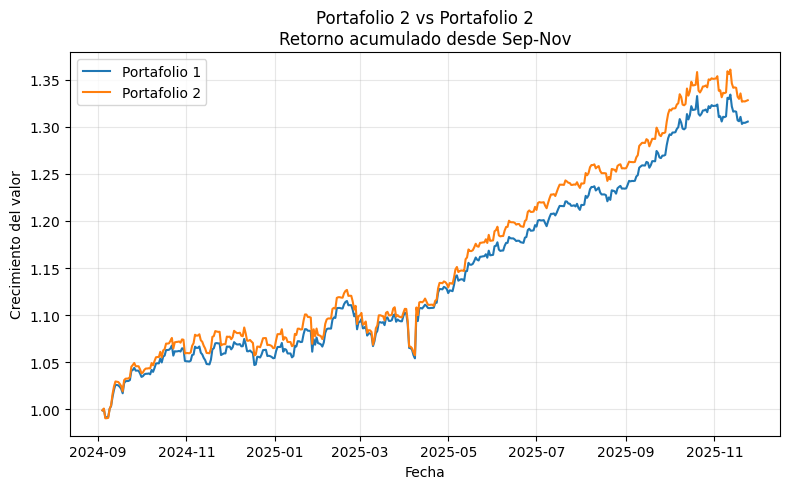

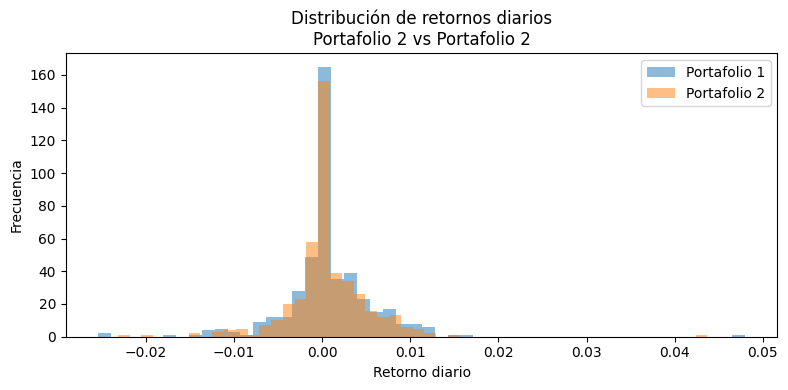

In [20]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# ==========================
# 1. Parámetros generales
# ==========================

tickers = ["SHY","GLD","TIP","NVDA","KO","BTC-USD","JPM","TSLA","AAPL","IEF"]

start_date = "2024-09-01"
end_date = None  # None = hasta la fecha actual

# ==========================
# 2. Descargar precios
# ==========================

data = yf.download(tickers, start=start_date, end=end_date)["Close"]
data = data.dropna(how="all")  # por si hay días sin datos

# ==========================
# 3. Retornos diarios
# ==========================

returns = data.pct_change().dropna()

# ==========================
# 4. Definir pesos de los portafolios
# ==========================

# Portafolio 2 (el inicial que diste)
w1 = pd.Series({
    "SHY": 0.25,
    "GLD": 0.25,
    "TIP": 0.1998,
    "NVDA": 0.1551,
    "KO": 0.0810,
    "BTC-USD": 0.0260,
    "JPM": 0.0190,
    "TSLA": 0.0140,
    "AAPL": 0.0050,
    "IEF": 0.0
})

# Portafolio 2
w2 = pd.Series({
    "SHY": 0.25,
    "GLD": 0.25,
    "TIP": 0.2029,
    "NVDA": 0.1280,
    "KO": 0.0833,
    "BTC-USD": 0.0275,
    "JPM": 0.0211,
    "AAPL": 0.0199,
    "IEF": 0.0113,
    "TSLA": 0.0061
})

# Alinear con el universo de tickers y normalizar (por si acaso)
w1 = w1.reindex(tickers).fillna(0.0)
w2 = w2.reindex(tickers).fillna(0.0)

w1 = w1 / w1.sum()
w2 = w2 / w2.sum()

print("Pesos Portafolio 2:\n", w1, "\n")
print("Pesos Portafolio 2:\n", w2, "\n")

# ==========================
# 5. Retornos diarios de cada portafolio
# ==========================

ret_p1 = (returns[tickers] @ w1)
ret_p2 = (returns[tickers] @ w2)

df_ports = pd.DataFrame({
    "Portafolio 2": ret_p1,
    "Portafolio 1": ret_p2
})

# ==========================
# 6. Retornos acumulados (equity curve)
# ==========================

cum_p1 = (1 + ret_p1).cumprod()
cum_p2 = (1 + ret_p2).cumprod()

cum_df = pd.DataFrame({
    "Portafolio 2": cum_p1,
    "Portafolio 1": cum_p2
})

# ==========================
# 7. Métricas de comparación
# ==========================

def metrics(ret_series, name="", rf=0.0):
    """
    ret_series: retornos diarios
    rf: tasa libre de riesgo diaria (ej: 0.0 para simplificar)
    """
    mean_daily = ret_series.mean()
    vol_daily = ret_series.std()
    sharpe = (mean_daily - rf) / vol_daily if vol_daily > 0 else np.nan
    mean_annual = (1 + mean_daily)**252 - 1
    vol_annual = vol_daily * np.sqrt(252)
    return pd.Series({
        "Media diaria": mean_daily,
        "Vol diaria": vol_daily,
        "Sharpe (diario)": sharpe,
        "Media anual": mean_annual,
        "Vol anual": vol_annual
    }, name=name)

rf_daily = 0.0  # si quieres puedes cambiar esto usando TBIL

m1 = metrics(ret_p1, "Portafolio 1", rf=rf_daily)
m2 = metrics(ret_p2, "Portafolio 2", rf=rf_daily)

resumen = pd.concat([m1, m2], axis=1)
#print("\n=== Métricas comparativas (desde 2024-09-01) ===\n")
#print(resumen)

# ==========================
# 8. Gráfico: Retorno acumulado
# ==========================

plt.figure(figsize=(8,5))
plt.plot(cum_df.index, cum_df["Portafolio 1"], label="Portafolio 1")
plt.plot(cum_df.index, cum_df["Portafolio 2"], label="Portafolio 2")
plt.title("Portafolio 2 vs Portafolio 2\nRetorno acumulado desde Sep-Nov")
plt.xlabel("Fecha")
plt.ylabel("Crecimiento del valor")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ==========================
# 9. Gráfico: Retorno diario (opcional)
# ==========================

plt.figure(figsize=(8,4))
plt.hist(ret_p1, bins=50, alpha=0.5, label="Portafolio 1")
plt.hist(ret_p2, bins=50, alpha=0.5, label="Portafolio 2")
plt.title("Distribución de retornos diarios\nPortafolio 2 vs Portafolio 2")
plt.xlabel("Retorno diario")
plt.ylabel("Frecuencia")
plt.legend()
plt.tight_layout()
#plt.show()
